In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np


In [2]:
from sklearn.datasets import make_classification

# Create synthetic data
X, y = make_classification(n_samples=10000, n_features=20, 
                           n_classes=2, weights=[0.9, 0.1], 
                           random_state=42)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(f"Train class distribution: {np.bincount(y_train)}")
print(f"Test class distribution: {np.bincount(y_test)}")


Train class distribution: [7192  808]
Test class distribution: [1776  224]


In [3]:
def weighted_binary_crossentropy(class_weights):
    def loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)  # Prevent log(0)
        loss = -(
            class_weights[1] * y_true * tf.math.log(y_pred) + 
            class_weights[0] * (1 - y_true) * tf.math.log(1 - y_pred)
        )
        return tf.reduce_mean(loss)
    return loss

# Define class weights (inverse of class distribution)
class_counts = np.bincount(y_train)
class_weights = {0: 1.0 / class_counts[0], 1: 1.0 / class_counts[1]}

print(f"Class Weights: {class_weights}")


Class Weights: {0: 0.00013904338153503893, 1: 0.0012376237623762376}


In [4]:
def build_model():
    model = Sequential([
        Input(shape=(20,)),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    return model


In [5]:
# Standard binary crossentropy loss
model_standard = build_model()
model_standard.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history_standard = model_standard.fit(X_train, y_train, 
                                      epochs=10, 
                                      batch_size=64, 
                                      validation_data=(X_test, y_test))


Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 14s 21ms/step - accuracy: 0.7015 - loss: 0.5095 - val_accuracy: 0.9200 - val_loss: 0.1829
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9316 - loss: 0.1801 - val_accuracy: 0.9345 - val_loss: 0.1470
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9411 - loss: 0.1621 - val_accuracy: 0.9430 - val_loss: 0.1353
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9463 - loss: 0.1515 - val_accuracy: 0.9435 - val_loss: 0.1334
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9416 - loss: 0.1483 - val_accuracy: 0.9445 - val_loss: 0.1308
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9454 - loss: 0.1489 - val_accuracy: 0.9440 - val_loss: 0.1288
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9451 - loss: 0.1524 - val_accuracy: 0.9460 - val_loss: 0.1264
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9487 - loss: 0.1400 - val_accuracy: 

In [6]:
# Custom weighted loss
model_custom = build_model()
custom_loss = weighted_binary_crossentropy(class_weights)
model_custom.compile(optimizer='adam', loss=custom_loss, metrics=['accuracy'])

history_custom = model_custom.fit(X_train, y_train, 
                                  epochs=10, 
                                  batch_size=64, 
                                  validation_data=(X_test, y_test))


Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - accuracy: 0.8200 - loss: 1.6276e-04 - val_accuracy: 0.8485 - val_loss: 8.2217e-05
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.8660 - loss: 8.4515e-05 - val_accuracy: 0.8830 - val_loss: 6.7433e-05
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8873 - loss: 7.4776e-05 - val_accuracy: 0.9125 - val_loss: 6.2722e-05
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9035 - loss: 7.1195e-05 - val_accuracy: 0.8955 - val_loss: 6.0729e-05
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9024 - loss: 6.6900e-05 - val_accuracy: 0.8915 - val_loss: 5.9562e-05
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8945 - loss: 7.0279e-05 - val_accuracy: 0.9215 - val_loss: 5.6730e-05
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9187 - loss: 6.6156e-05 - val_accuracy: 0.9175 - val_loss: 5.6549e-05
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms

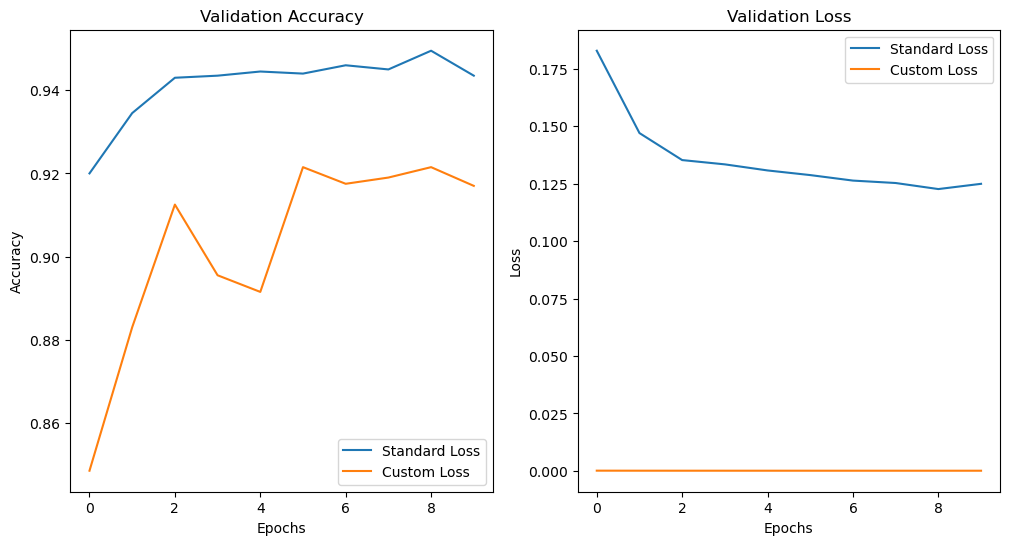

Standard Loss Model Evaluation:
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9373 - loss: 0.1384

Custom Loss Model Evaluation:
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9131 - loss: 6.4644e-05


[5.472008342621848e-05, 0.9169999957084656]

In [7]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))

# Accuracy comparison
plt.subplot(1, 2, 1)
plt.plot(history_standard.history['val_accuracy'], label='Standard Loss')
plt.plot(history_custom.history['val_accuracy'], label='Custom Loss')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss comparison
plt.subplot(1, 2, 2)
plt.plot(history_standard.history['val_loss'], label='Standard Loss')
plt.plot(history_custom.history['val_loss'], label='Custom Loss')
plt.title('Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Evaluate models
print("Standard Loss Model Evaluation:")
model_standard.evaluate(X_test, y_test)

print("\nCustom Loss Model Evaluation:")
model_custom.evaluate(X_test, y_test)
